In [43]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors, __version__ as mplver
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from astropy.table import Table
from astropy import __version__ as apver
from astropy import units as u, constants as c
from scipy import stats, __version__ as spver
import warnings
from TESStools import *
from tqdm.notebook import tqdm
from matplotlib import lines as mlines
from matplotlib.colors import Normalize
from scipy.stats import sigmaclip
import h5py as h5

In [2]:
print(np.__version__,pd.__version__,mplver,apver,spver)

1.20.3 1.3.0 3.3.4 4.2.1 1.6.2


In [3]:
#We're going to need our stars...
cool_sgs = pd.read_csv('sample.csv',index_col=0)
#merged with SLFV and prewhitening info...
slfv_params = pd.read_csv('slfv_params.csv',index_col=0)
inspected = pd.read_csv('prewhitening.csv',index_col=0)
merged = pd.merge(cool_sgs,slfv_params,left_index=True,right_index=True)
merged = pd.merge(merged,inspected,left_index=True,right_index=True)

# Now we're going to look for pulsators. First, grab stars where we can extract a frequency with >5 sigma

# Grab stars where we can extract a frequency with >5 sigma
pulse_detected = merged[(merged['n_peaks'] > 0) & (merged['highest_amp']/merged['highest_amp_error'] > 5)]
print(f"{len(pulse_detected)} stars with 5-sigma frequencies out of {len(merged)} total")

# We also used a GP to see if these frequencies were significant above the SLFV
gp_pulse = pd.read_csv('Find_FYPS_GP_results.csv', index_col=0)
pulse_detected_gp = pd.merge(pulse_detected, gp_pulse, left_index=True, right_index=True)
print(f"GP reveals {len(pulse_detected_gp[pulse_detected_gp['pulse_GP']==True])} true periodic stars")

# Load in info on which stars are consistent with RR Lyrae and Beta Cepheids...
likely_rrcep = pd.read_csv('likelyRRCep.csv',index_col=0)
likely_bcep = pd.read_csv('likelyBCep.csv',index_col=0)
contaminants = pd.merge(likely_rrcep,likely_bcep,left_index=True,right_index=True)

new = pd.merge(pulse_detected_gp,contaminants,left_index=True,right_index=True)
pulse_clean = new[(new['pulse_GP'])&(~new['LikelyRR'])&(~new['LikelyCep'])&(~new['LikelyBCep'])]
print(f"Filtering out contaminants leaves us with {len(pulse_clean)} stars")

155 stars with 5-sigma frequencies out of 201 total
GP reveals 154 true periodic stars
Filtering out contaminants leaves us with 111 stars


In [4]:
#A way to grab FYPS
def fyps_box(df):
    """
    Returns part of dataframe where teff and lum are in the FYPS box
    """
    
    #tmin = df['teff'] >= 3.6
    #tmax = df['teff'] <= 4.1
    #lmax = df['lum'] <= 7.76 - 0.6*df['teff']
    lmin = df['lum'] >= 5.0 #6.23 - 0.3*df['teff']
    
    return lmin # & lmax & tmin & tmax

In [5]:
candidate_fyps = pulse_clean[fyps_box(pulse_clean)]
all_in_box = merged[fyps_box(merged)]
len(candidate_fyps), len(all_in_box), len(candidate_fyps)/len(all_in_box)

(39, 63, 0.6190476190476191)

In [15]:
nf = []
highf = []
lowf = []
teff = []
for tic, cf in candidate_fyps.iterrows():
    teff.append(cf['teff'])
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()][:,0]
        nf.append(len(good_fs))
        highf.append(good_fs.max())
        lowf.append(good_fs.min())

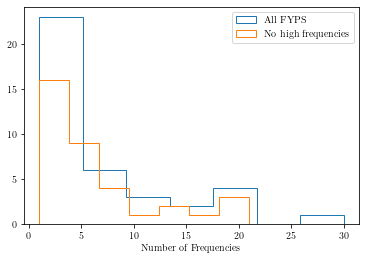

In [9]:
plt.hist(nf, histtype='step',bins='auto',label='All FYPS')
plt.hist(np.array(nf)[np.array(highf)<30], histtype='step',bins='auto',label='No high frequencies')
plt.xlabel('Number of Frequencies')
plt.legend()

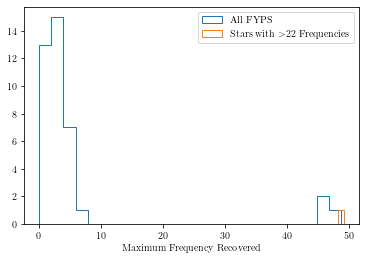

In [11]:
plt.hist(highf, histtype='step', bins='auto',label='All FYPS')
plt.hist(np.array(highf)[np.array(nf)>22], histtype='step', bins='auto', label='Stars with $>$22 Frequencies')
plt.xlabel('Maximum Frequency Recovered')
plt.legend()

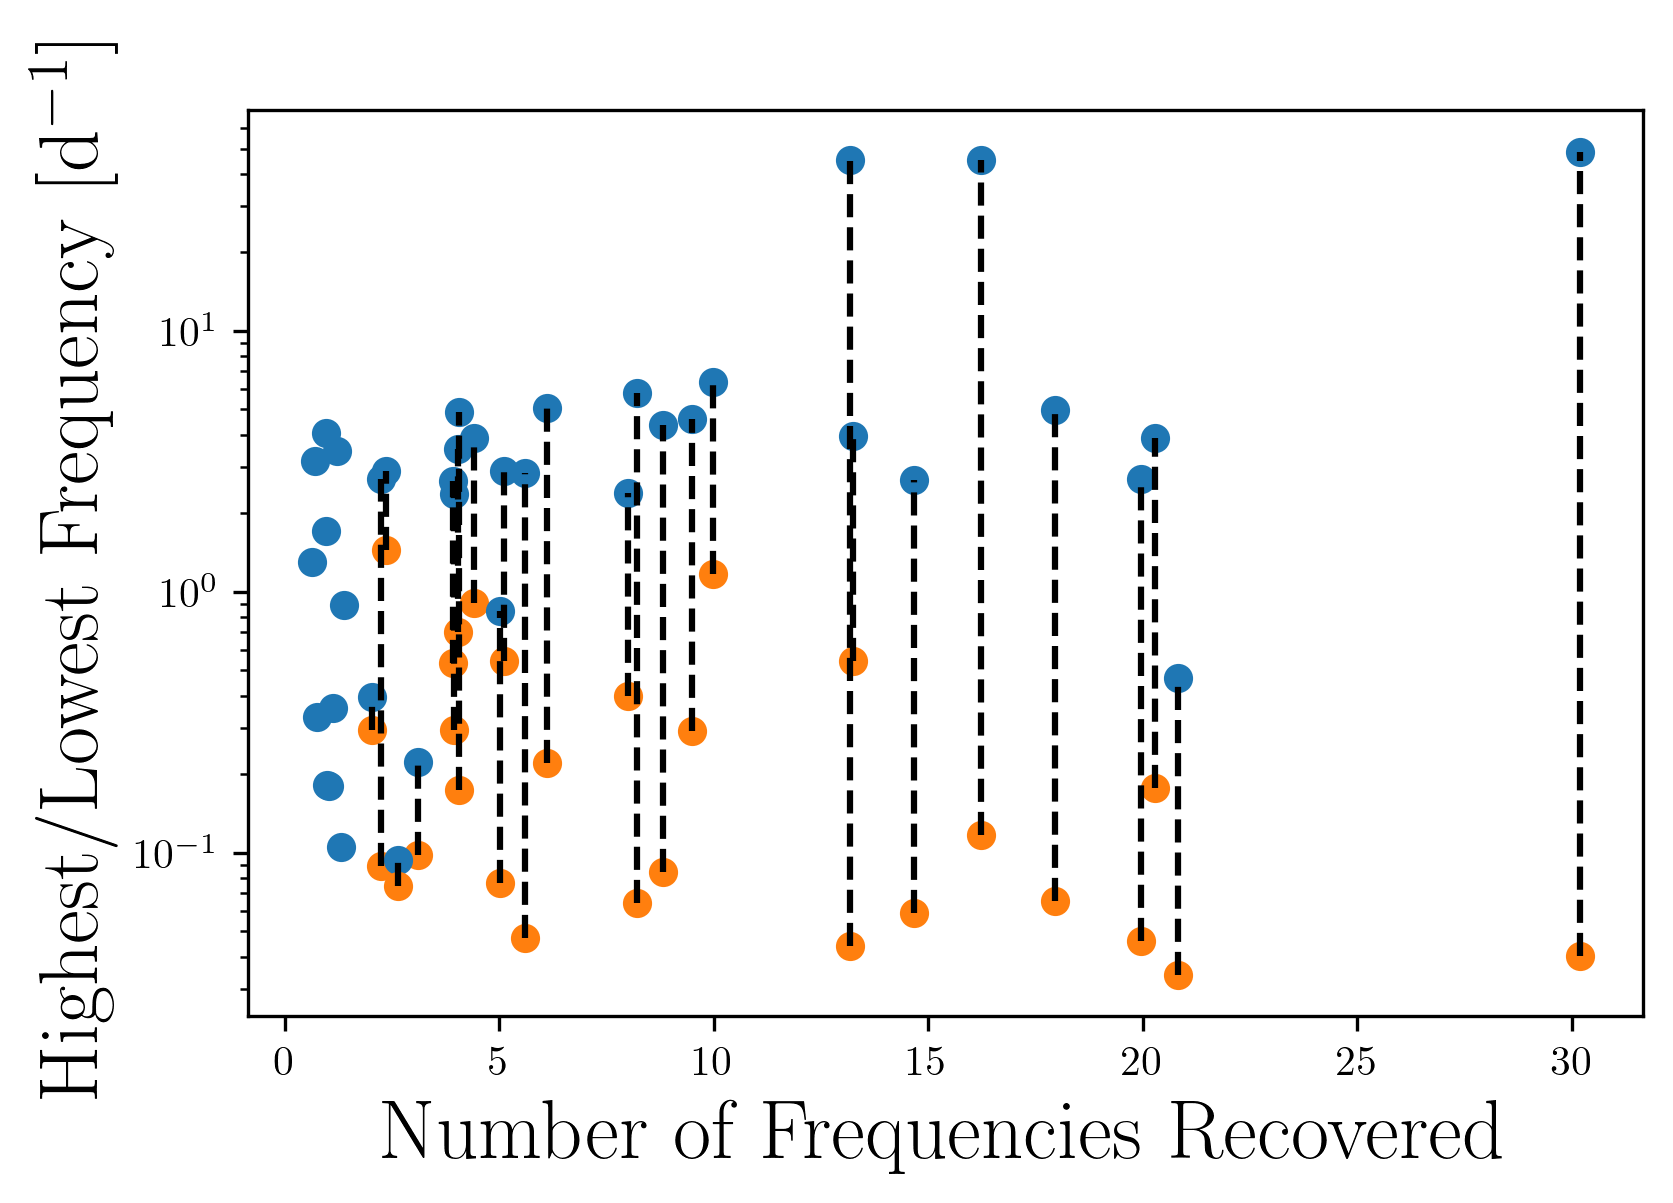

In [31]:
fig = plt.figure(dpi=300)
for i in range(len(nf)):
    offset= 0.2*np.random.randn() 
    plt.scatter(nf[i]+offset,highf[i],c='C0')
    if nf[i] != 1:
        plt.scatter(nf[i]+offset,lowf[i],c='C1')
        plt.plot([nf[i]+offset,nf[i]+offset],[lowf[i],highf[i]],ls='--',c='k')
    
plt.xlabel('Number of Frequencies Recovered',fontsize=20)
plt.ylabel('Highest/Lowest Frequency [d$^{-1}$]',fontsize=20)
plt.yscale('log')
plt.savefig('../plots/FYPS_freq_props.pdf',bbox_inches='tight')

# Let's make a plot showing the evolution of FYPS frequencies along the HR diagram

# Azalee suggested making a density plot, which is a great idea! First we need to transform into a space where the KDE kernel is not stretched along one axis or another

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from matplotlib.patches import Ellipse

filter_high_frequencies = True
filter_many_frequencies = True
scale_tdyn = False
KDE_res = 1000 #resolution of KDE

scaler = StandardScaler()
x_data = []
y_data = []
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            lum_erg = (np.power(10.0,cf['lum'])*u.Lsun).to(u.erg/u.s)
            t_kelv = np.power(10.0,cf['teff'])*u.Kelvin
            sigma_T4 = c.sigma_sb * np.power(t_kelv, 4.0)
            r_2 = lum_erg / sigma_T4 / (4.0*np.pi*np.pi)
            rcm = np.sqrt(r_2).to(u.cm)
            M = 15.0*u.Msun
            tdyn = np.sqrt((rcm**3.0) / (2*c.G*M)).to(u.d)
            y *= tdyn
        y_data.append(y)
    
data = np.array([x_data,y_data]).T
data_scaled = scaler.fit_transform(data)
data_scaled_teff = data_scaled[:,0][:,np.newaxis]
data_scaled_teff


# First we're going to do a KDE along the Teff axis to account for distribution in HR diagram
#params = {'bandwidth': np.arange(0.1,0.4,0.0001)}
#grid = GridSearchCV(KernelDensity(), params)
#grid.fit(data_scaled_teff)
  
teff_bandwidth = 0.5 #grid.best_estimator_.bandwidth
print(teff_bandwidth)

kde_teff = KernelDensity(bandwidth=teff_bandwidth)
kde_teff.fit(data_scaled_teff)

xteff = np.linspace(data_scaled_teff.min(),data_scaled_teff.max(),KDE_res)

#compute the KDE
Z_teff = np.exp(kde_teff.score_samples(xteff.reshape(-1, 1)))

#Now we do the same in T vs. freq space
#params = {'bandwidth': np.arange(0.01,0.4,0.001)}
#grid = GridSearchCV(KernelDensity(), params)

#grid.fit(data_scaled)
    
fteff_bandwidth = 0.5 #grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data_scaled)

X, Y = np.meshgrid(np.linspace(np.min(data_scaled[:,0]),np.max(data_scaled[:,0]),KDE_res), 
                   np.linspace(np.min(data_scaled[:,1]),np.max(data_scaled[:,1]),KDE_res))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (KDE_res,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

mesh_inv = scaler.inverse_transform(xy).reshape(KDE_res,KDE_res,2)
X_inv = mesh_inv[:,:,0]
Y_inv = mesh_inv[:,:,1]

0.5
0.5


In [69]:
widths = [[0.0,0.0],[0.0,fteff_bandwidth],[fteff_bandwidth,0.0]]
width_inv = scaler.inverse_transform(widths)
y_width = np.abs(width_inv[0,1]-width_inv[1,1])
x_width = np.abs(width_inv[0,0]-width_inv[2,0])
x_width,y_width

(0.07186146251076586, 0.7584992512598852)

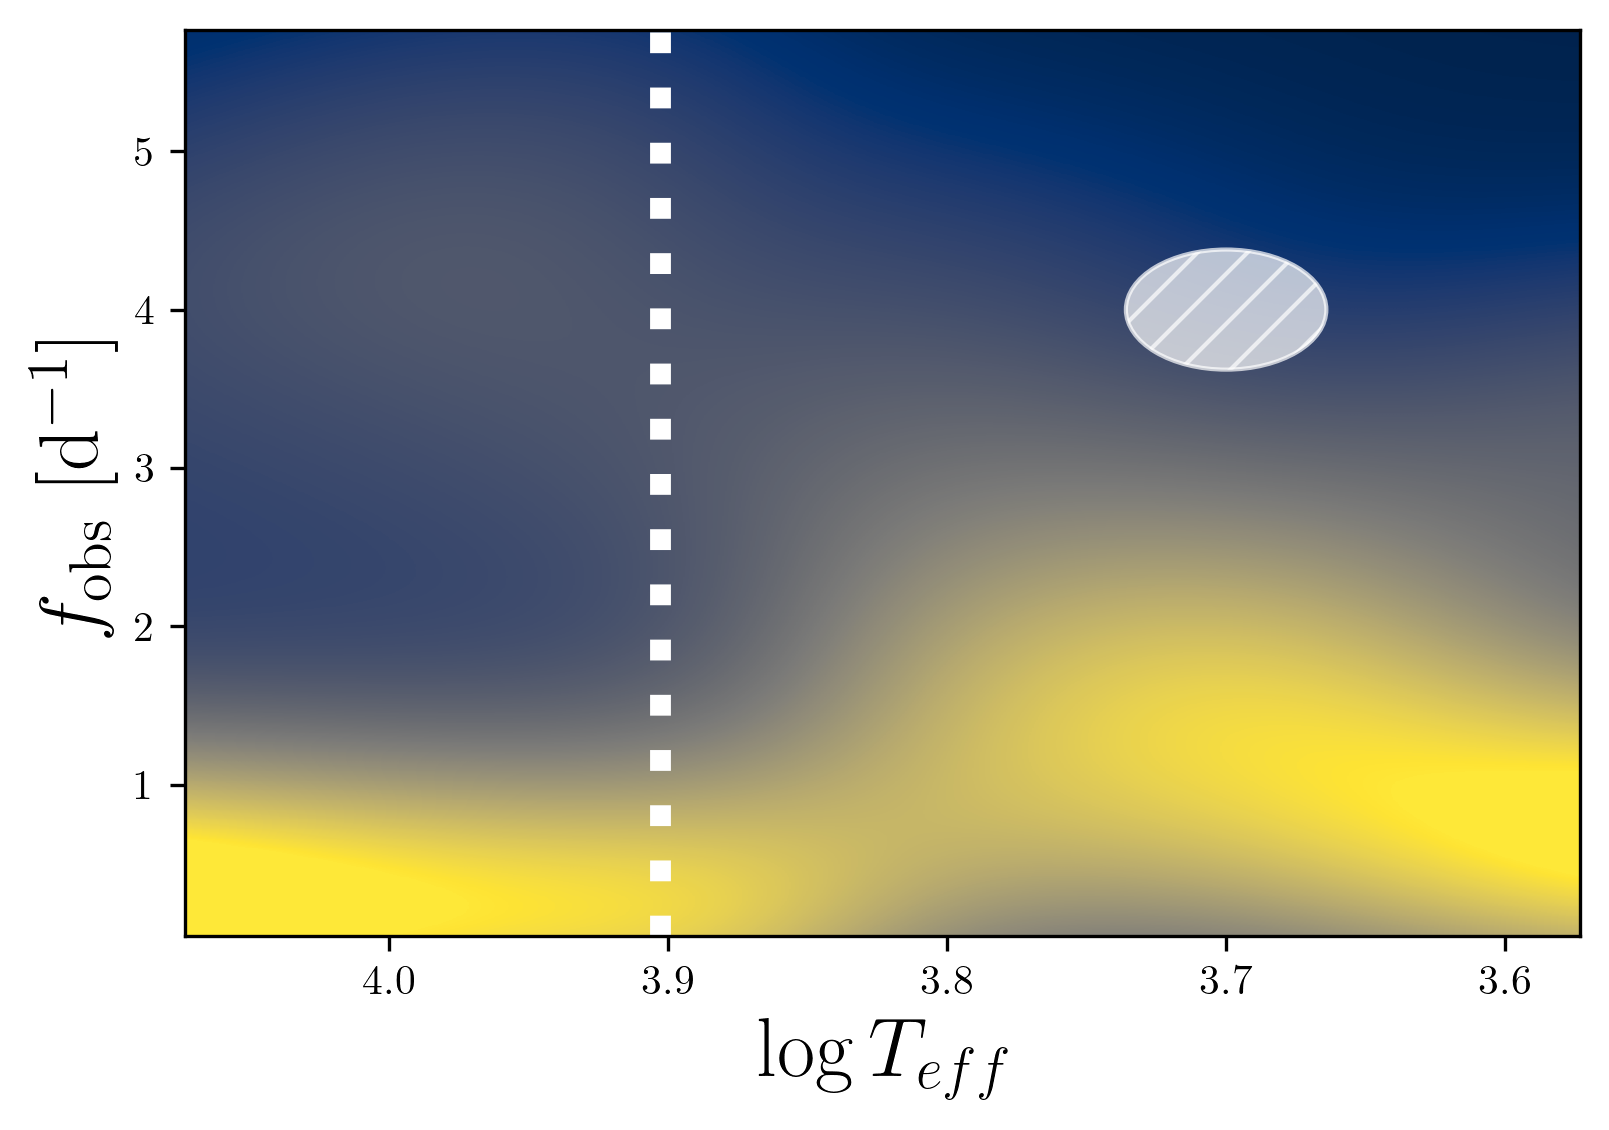

In [71]:
#Make the plot in inverse_scaled space
fig = plt.figure(dpi=300)
plt.pcolormesh(X_inv, Y_inv, Z_fteff_scale, shading='nearest', cmap='cividis',vmin=0,vmax=0.5, rasterized=True)

widths = [[0.0,0.0],[0.0,fteff_bandwidth],[fteff_bandwidth,0.0]]
width_inv = scaler.inverse_transform(widths)
y_width = np.abs(width_inv[0,1]-width_inv[1,1])
x_width = np.abs(width_inv[0,0]-width_inv[2,0])

plt.xlabel(r'$\log T_{eff}$',fontsize=20)
plt.ylabel(r'$f_{\rm obs}$ [d$^{-1}$]',fontsize=20)

ax = plt.gca()
ax.add_patch(Ellipse((3.7, 4.0), x_width, y_width, angle=0, alpha=0.7,edgecolor='w',facecolor='w',lw=1,hatch='//'))
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.invert_xaxis()

plt.savefig('../plots/fobs_teff.pdf', bbox_inches='tight')

# Same plot, with frequencies scaled by estimated Tdyn

In [74]:
filter_high_frequencies = True
filter_many_frequencies = True
scale_tdyn = True
KDE_res = 1000 #resolution of KDE

scaler = StandardScaler()
x_data = []
y_data = []
rsuns = []
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            lum_erg = (np.power(10.0,cf['lum'])*u.Lsun).to(u.erg/u.s)
            t_kelv = np.power(10.0,cf['teff'])*u.Kelvin
            sigma_T4 = c.sigma_sb * np.power(t_kelv, 4.0)
            r_2 = lum_erg / sigma_T4 / (4.0*np.pi*np.pi)
            rcm = np.sqrt(r_2).to(u.cm)
            rsuns.append(rcm.to(u.Rsun))
            M = 15.0*u.Msun
            tdyn = np.sqrt((rcm**3.0) / (2*c.G*M)).to(u.d)
            y *= tdyn.value
        y_data.append(y)
    
data = np.array([x_data,y_data]).T
data_scaled = scaler.fit_transform(data)
data_scaled_teff = data_scaled[:,0][:,np.newaxis]
data_scaled_teff


# First we're going to do a KDE along the Teff axis to account for distribution in HR diagram
#params = {'bandwidth': np.arange(0.1,0.4,0.0001)}
#grid = GridSearchCV(KernelDensity(), params)
#grid.fit(data_scaled_teff)
  
teff_bandwidth = 0.5 #grid.best_estimator_.bandwidth
print(teff_bandwidth)

kde_teff = KernelDensity(bandwidth=teff_bandwidth)
kde_teff.fit(data_scaled_teff)

xteff = np.linspace(data_scaled_teff.min(),data_scaled_teff.max(),KDE_res)

#compute the KDE
Z_teff = np.exp(kde_teff.score_samples(xteff.reshape(-1, 1)))

#Now we do the same in T vs. freq space
#params = {'bandwidth': np.arange(0.01,0.4,0.001)}
#grid = GridSearchCV(KernelDensity(), params)

#grid.fit(data_scaled)
    
fteff_bandwidth = 0.5 #grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data_scaled)

X, Y = np.meshgrid(np.linspace(np.min(data_scaled[:,0]),np.max(data_scaled[:,0]),KDE_res), 
                   np.linspace(np.min(data_scaled[:,1]),np.max(data_scaled[:,1]),KDE_res))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (KDE_res,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

mesh_inv = scaler.inverse_transform(xy).reshape(KDE_res,KDE_res,2)
X_inv = mesh_inv[:,:,0]
Y_inv = mesh_inv[:,:,1]

0.5
0.5


In [77]:
np.array([r.value for r in rsuns])*u.Rsun

<Quantity [609.781972  , 381.57351658, 381.57351658, 381.57351658,
           381.57351658, 473.78163738, 473.78163738, 445.73652661,
           516.50939385, 347.59876481, 347.59876481, 347.59876481,
           347.59876481, 467.81939668, 467.81939668, 467.81939668,
           467.81939668, 228.33801669, 228.33801669, 228.33801669,
           228.33801669, 228.33801669, 228.33801669, 228.33801669,
           228.33801669, 250.94481371, 250.94481371, 250.94481371,
           250.94481371, 250.94481371, 195.24423736, 195.24423736,
           195.24423736, 195.24423736, 195.24423736, 195.24423736,
           195.24423736, 195.24423736, 195.24423736, 231.24812736,
           231.24812736, 153.66615497, 129.74129382, 129.74129382,
           129.74129382, 136.64011678, 136.64011678, 119.14565922,
           119.14565922, 119.14565922, 100.82732018, 108.91262476,
           104.25051871, 109.5413842 , 120.52530093, 120.52530093,
           120.52530093, 120.52530093, 120.52530093, 120.52530

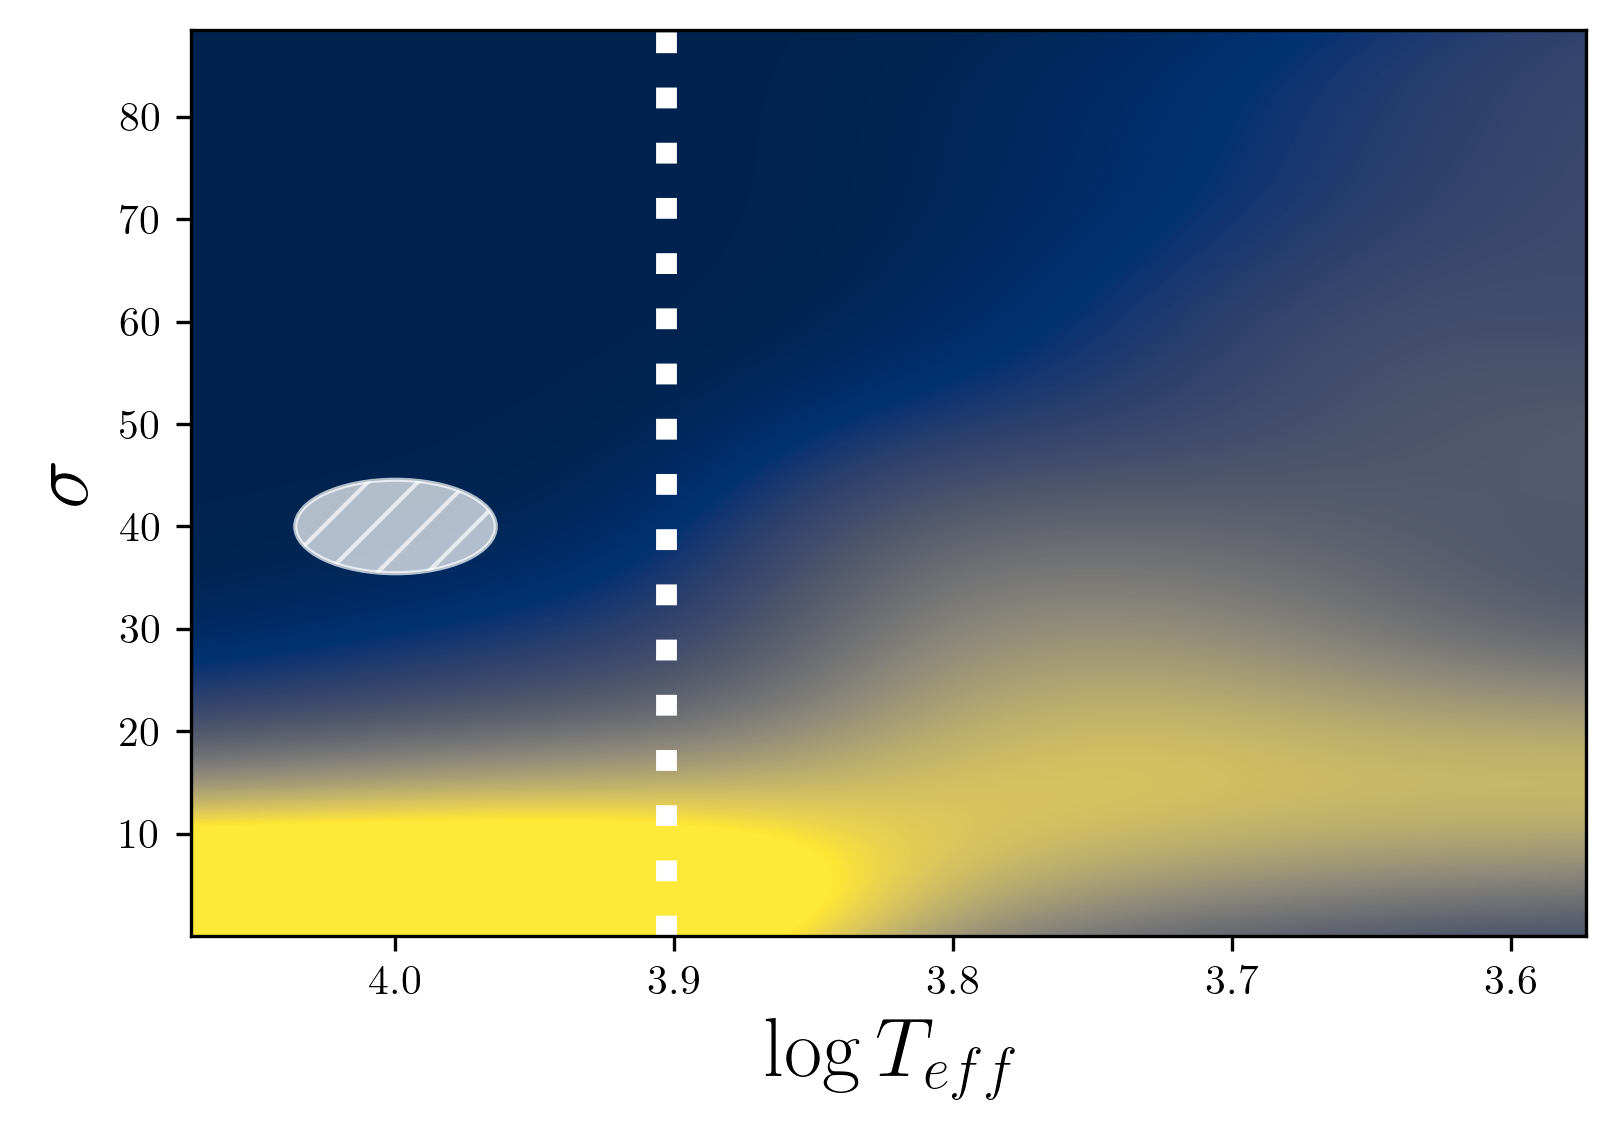

In [73]:
#Make the plot in inverse_scaled space
fig = plt.figure(dpi=300)
plt.pcolormesh(X_inv, Y_inv, Z_fteff_scale, shading='nearest', cmap='cividis',vmin=0.0,vmax=0.5, rasterized=True)

widths = [[0.0,0.0],[0.0,fteff_bandwidth],[fteff_bandwidth,0.0]]
width_inv = scaler.inverse_transform(widths)
y_width = np.abs(width_inv[0,1]-width_inv[1,1])
x_width = np.abs(width_inv[0,0]-width_inv[2,0])

plt.xlabel(r'$\log T_{eff}$',fontsize=20)
plt.ylabel(r'$\sigma$',fontsize=20)

ax = plt.gca()
ax.add_patch(Ellipse((4.0, 40), x_width, y_width, angle=0, alpha=0.7,edgecolor='w',facecolor='w',lw=1,hatch='//'))
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.invert_xaxis()
plt.savefig('../plots/sigma_teff.pdf', bbox_inches='tight')

# Throwing in things with lots of frequencies...

In [93]:
filter_high_frequencies = True
filter_many_frequencies = False
scale_tdyn = True
KDE_res = 1000 #resolution of KDE

scaler = StandardScaler()
x_data = []
y_data = []
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn
        y_data.append(y)
    
data = np.array([x_data,y_data]).T
data_scaled = scaler.fit_transform(data)
data_scaled_teff = data_scaled[:,0][:,np.newaxis]
data_scaled_teff


# First we're going to do a KDE along the Teff axis to account for distribution in HR diagram
params = {'bandwidth': np.arange(0.1,0.4,0.0001)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data_scaled_teff)
  
teff_bandwidth = grid.best_estimator_.bandwidth
print(teff_bandwidth)

kde_teff = KernelDensity(bandwidth=teff_bandwidth)
kde_teff.fit(data_scaled_teff)

xteff = np.linspace(data_scaled_teff.min(),data_scaled_teff.max(),KDE_res)

#compute the KDE
Z_teff = np.exp(kde_teff.score_samples(xteff.reshape(-1, 1)))

#Now we do the same in T vs. freq space
params = {'bandwidth': np.arange(0.01,0.4,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data_scaled)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data_scaled)

X, Y = np.meshgrid(np.linspace(np.min(data_scaled[:,0]),np.max(data_scaled[:,0]),KDE_res), 
                   np.linspace(np.min(data_scaled[:,1]),np.max(data_scaled[:,1]),KDE_res))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (KDE_res,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

mesh_inv = scaler.inverse_transform(xy).reshape(KDE_res,KDE_res,2)
X_inv = mesh_inv[:,:,0]
Y_inv = mesh_inv[:,:,1]

0.40000000000000857
0.3989999999999997


[Text(0.5, 0, '$\\log T_{eff}$'), Text(0, 0.5, '$\\omega$')]

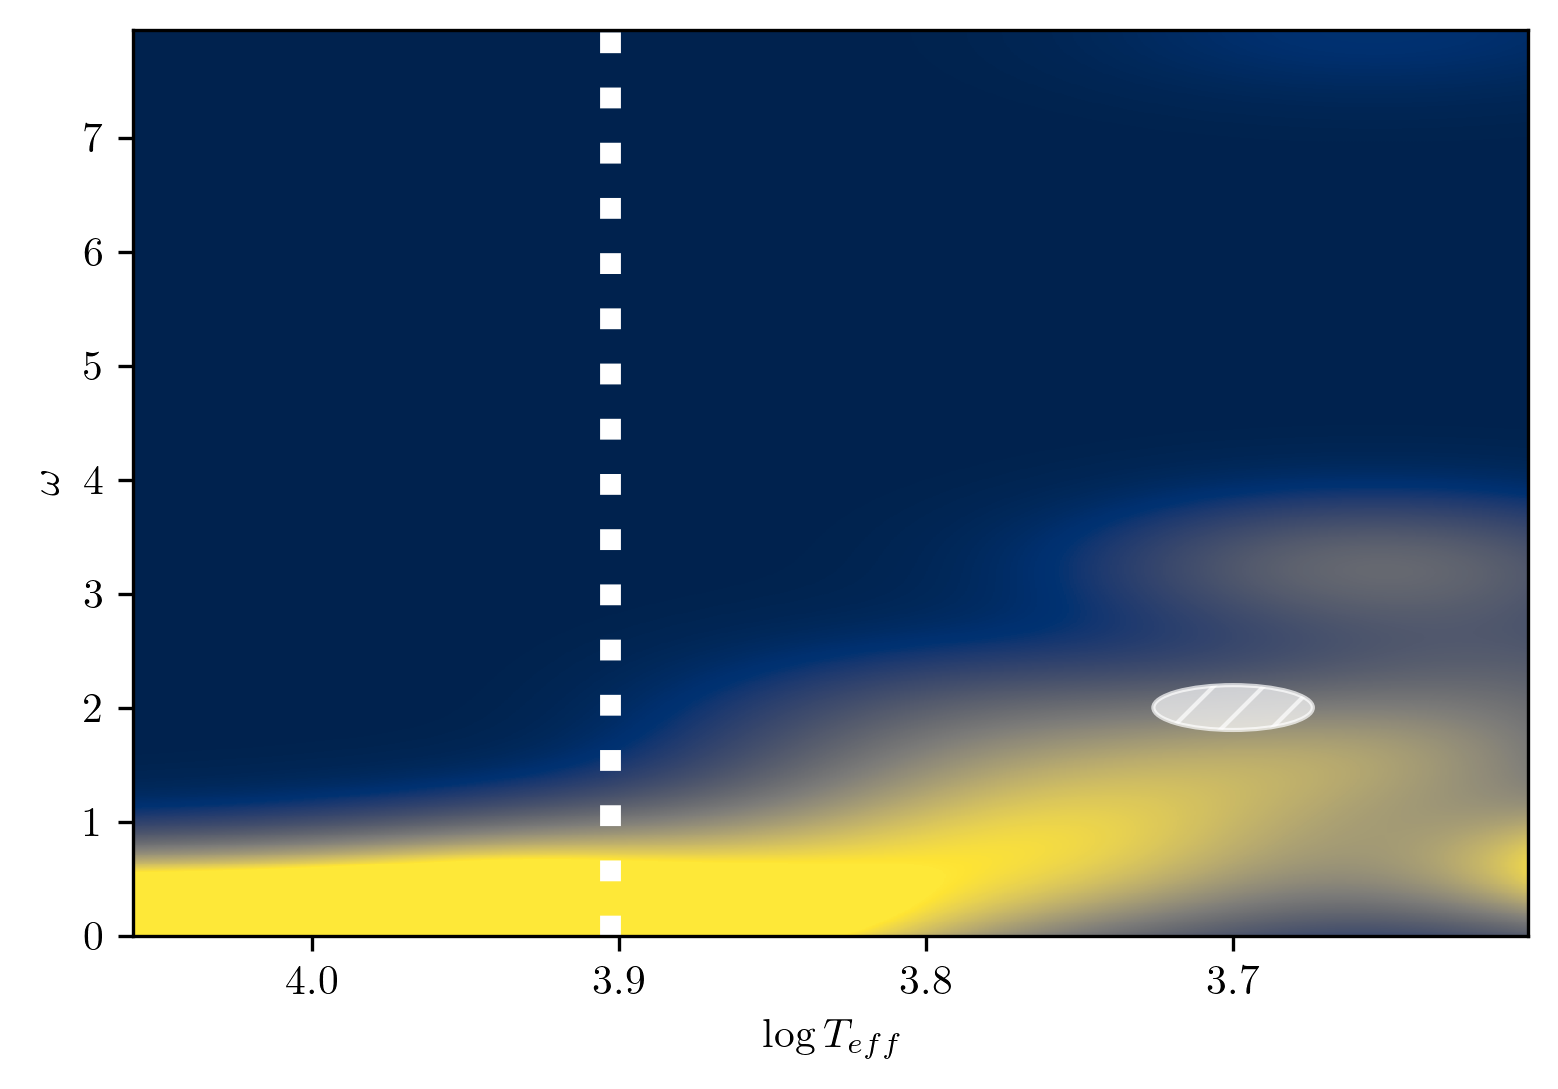

In [94]:
#Make the plot in inverse_scaled space
fig = plt.figure(dpi=300)
plt.pcolormesh(X_inv, Y_inv/1e-8, Z_fteff_scale, shading='nearest', cmap='cividis',vmin=0.0,vmax=0.5)

widths = [[0.0,0.0],[0.0,fteff_bandwidth],[fteff_bandwidth,0.0]]
width_inv = scaler.inverse_transform(widths)
y_width = np.abs(width_inv[0,1]-width_inv[1,1])
x_width = np.abs(width_inv[0,0]-width_inv[2,0])

ax = plt.gca()
ax.add_patch(Ellipse((3.7, 2.0), x_width, y_width/1e-8, angle=0, alpha=0.7,edgecolor='w',facecolor='w',lw=1,hatch='//'))
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.invert_xaxis()
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$\omega$')

# And objects with weirdly high frequencies

In [95]:
filter_high_frequencies = False
filter_many_frequencies = False
scale_tdyn = True
KDE_res = 1000 #resolution of KDE

scaler = StandardScaler()
x_data = []
y_data = []
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn
        y_data.append(y)
    
data = np.array([x_data,y_data]).T
data_scaled = scaler.fit_transform(data)
data_scaled_teff = data_scaled[:,0][:,np.newaxis]
data_scaled_teff


# First we're going to do a KDE along the Teff axis to account for distribution in HR diagram
params = {'bandwidth': np.arange(0.1,0.4,0.0001)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data_scaled_teff)
  
teff_bandwidth = grid.best_estimator_.bandwidth
print(teff_bandwidth)

kde_teff = KernelDensity(bandwidth=teff_bandwidth)
kde_teff.fit(data_scaled_teff)

xteff = np.linspace(data_scaled_teff.min(),data_scaled_teff.max(),KDE_res)

#compute the KDE
Z_teff = np.exp(kde_teff.score_samples(xteff.reshape(-1, 1)))

#Now we do the same in T vs. freq space
params = {'bandwidth': np.arange(0.01,0.4,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data_scaled)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data_scaled)

X, Y = np.meshgrid(np.linspace(np.min(data_scaled[:,0]),np.max(data_scaled[:,0]),KDE_res), 
                   np.linspace(np.min(data_scaled[:,1]),np.max(data_scaled[:,1]),KDE_res))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (KDE_res,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

mesh_inv = scaler.inverse_transform(xy).reshape(KDE_res,KDE_res,2)
X_inv = mesh_inv[:,:,0]
Y_inv = mesh_inv[:,:,1]

0.40000000000000857
0.3989999999999997


[Text(0.5, 0, '$\\log T_{eff}$'), Text(0, 0.5, '$\\omega$')]

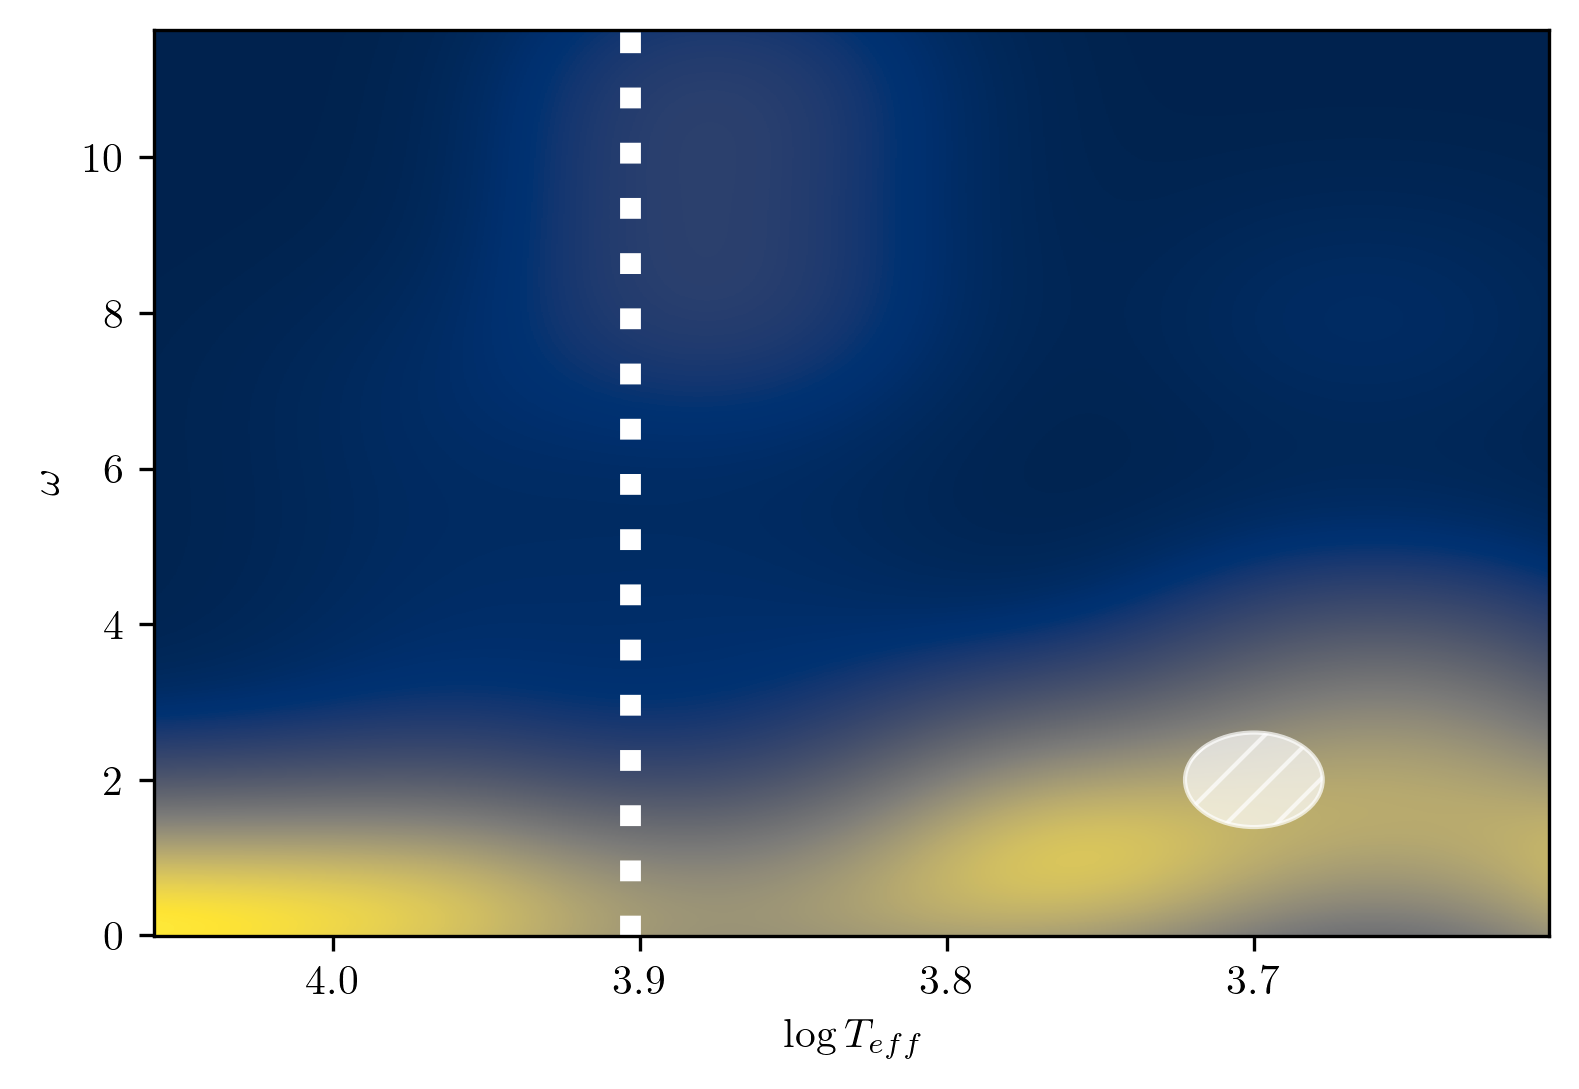

In [97]:
#Make the plot in inverse_scaled space
fig = plt.figure(dpi=300)
plt.pcolormesh(X_inv, Y_inv/1e-8, Z_fteff_scale, shading='nearest', cmap='cividis')

widths = [[0.0,0.0],[0.0,fteff_bandwidth],[fteff_bandwidth,0.0]]
width_inv = scaler.inverse_transform(widths)
y_width = np.abs(width_inv[0,1]-width_inv[1,1])
x_width = np.abs(width_inv[0,0]-width_inv[2,0])

ax = plt.gca()
ax.add_patch(Ellipse((3.7, 2.0), x_width, y_width/1e-8, angle=0, alpha=0.7,edgecolor='w',facecolor='w',lw=1,hatch='//'))
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.invert_xaxis()
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$\omega$')

0.09999999999999992


[Text(0.5, 0, '$\\log T_{eff}$'), Text(0, 0.5, '$f_{\\rm obs}$')]

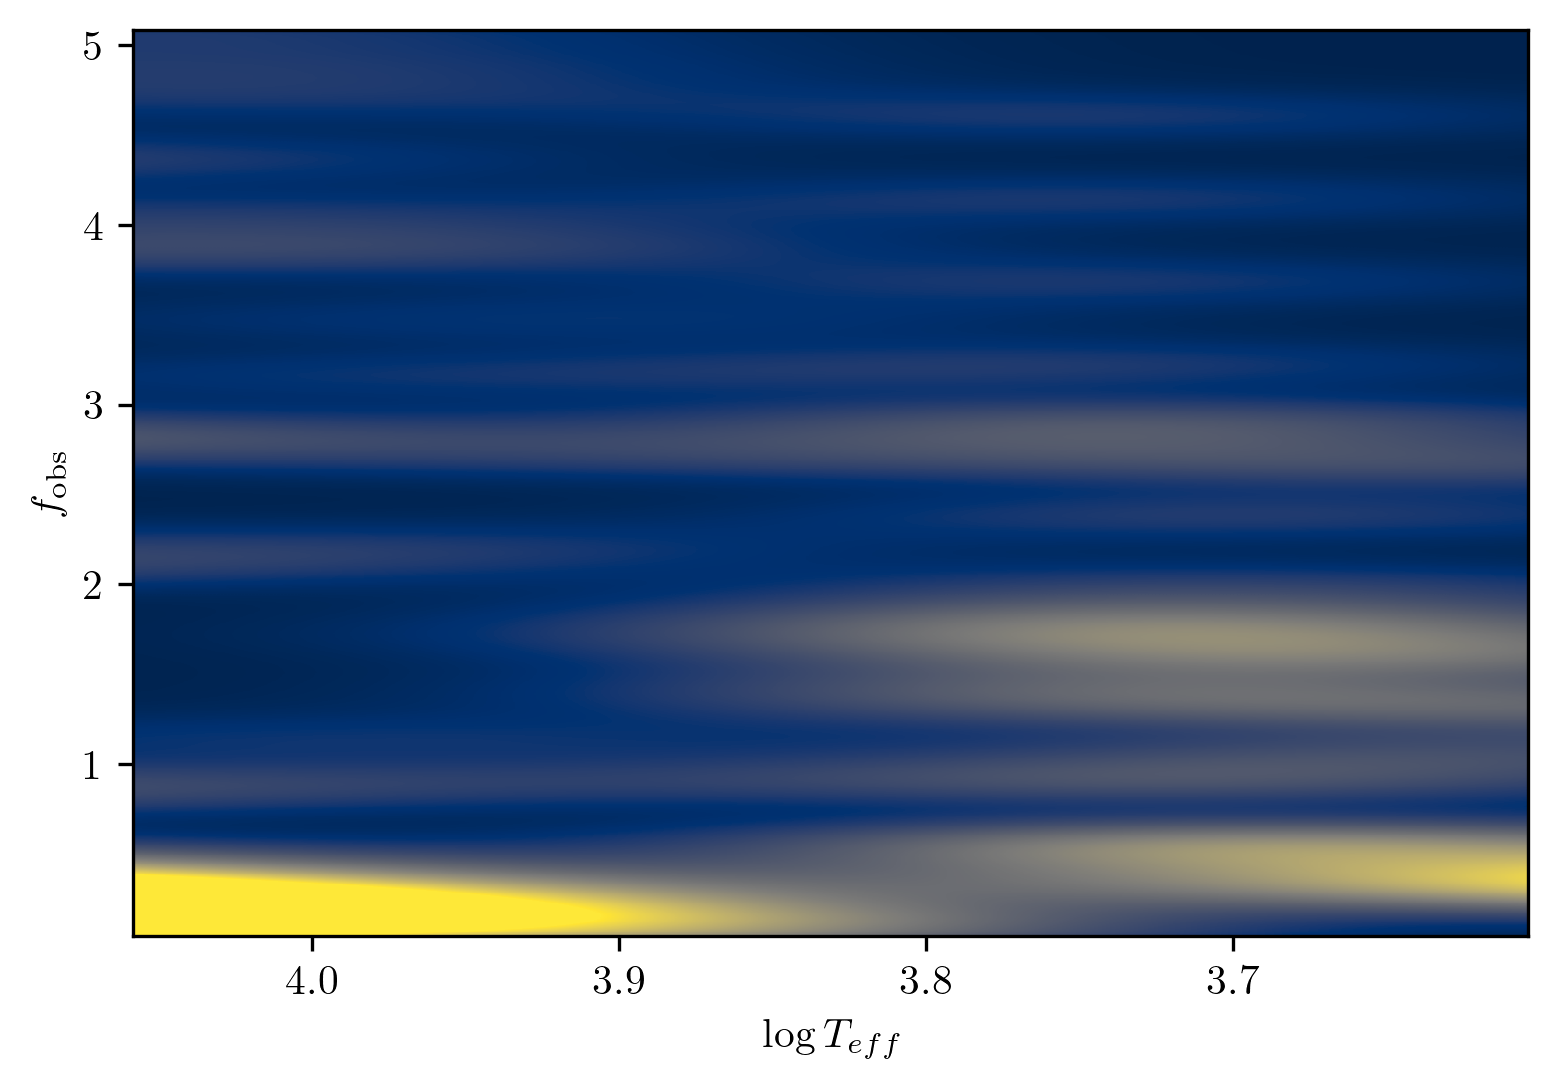

In [22]:
x_data = []
y_data = []
filter_high_frequencies = True
filter_many_frequencies = True
scale_tdyn = False
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn
        y_data.append(y)
    
data = np.array([x_data,y_data]).T

params = {'bandwidth': np.arange(0.01,0.1,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data)

X, Y = np.meshgrid(np.linspace(np.min(data[:,0]),np.max(data[:,0]),1000), 
                   np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (1000,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

fig = plt.figure(dpi=300)
plt.pcolormesh(X, Y, Z_fteff_scale, shading='nearest', cmap='cividis', vmin=0, vmax=1)

ax = plt.gca()
ax.invert_xaxis()
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$f_{\rm obs}$')

# And again, scaling by tdyn

0.09999999999999992


[Text(0.5, 0, '$\\log T_{eff}$'), Text(0, 0.5, '$\\omega/10^{-8}$')]

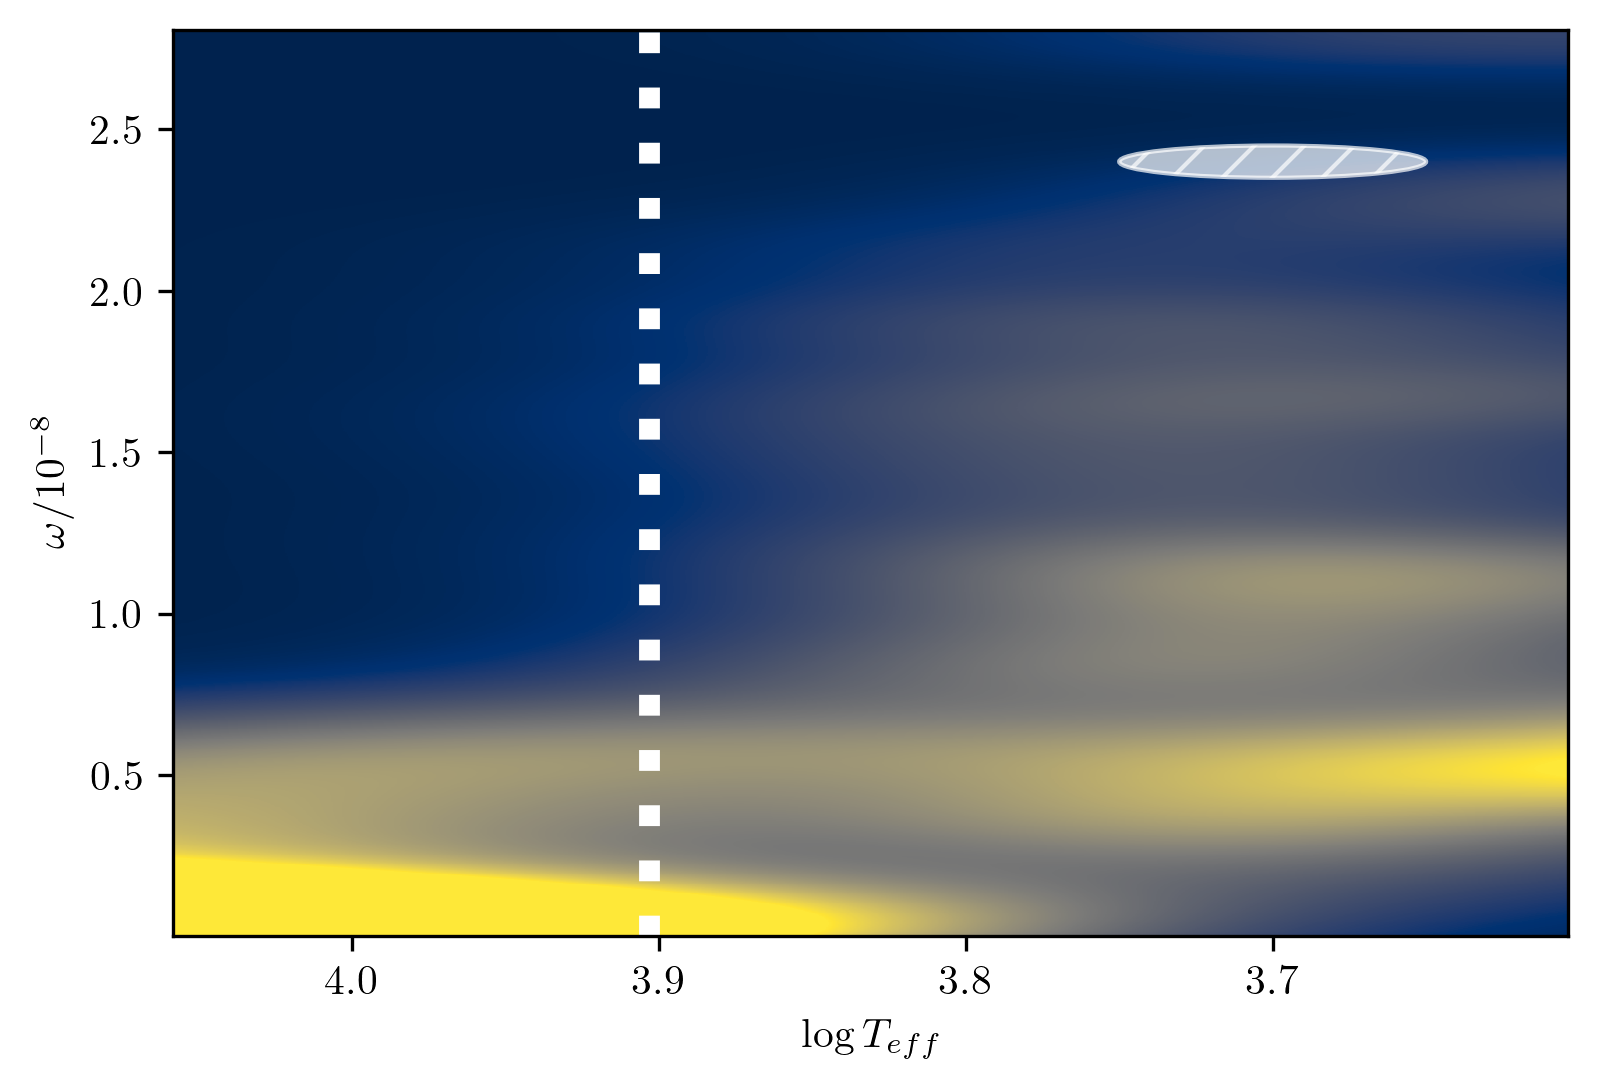

In [33]:
from astropy.constants import G
import astropy.units as u
from matplotlib.patches import Ellipse
Tsun = 5778
x_data = []
y_data = []
filter_high_frequencies = True
filter_many_frequencies = True
scale_tdyn = True
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn/1e-8
        y_data.append(y)
    
data = np.array([x_data,y_data]).T

params = {'bandwidth': np.arange(0.01,0.1,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data)

X, Y = np.meshgrid(np.linspace(np.min(data[:,0]),np.max(data[:,0]),1000), 
                   np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (1000,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

fig = plt.figure(dpi=300)
plt.pcolormesh(X, Y, Z_fteff_scale, shading='nearest', cmap='cividis', vmin=0, vmax=1)

ax = plt.gca()
ax.add_patch(Ellipse((4.0, 2.4), 0.1, 0.1, angle=0, alpha=0.7,edgecolor='w',facecolor='w',lw=1,hatch='//'))

ax.invert_xaxis()
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$\omega/10^{-8}$')

# Now let's actually keep the things that have lots of frequencies...

0.09999999999999992


[Text(0.5, 0, '$\\log T_{eff}$'), Text(0, 0.5, '$\\omega/10^{-8}$')]

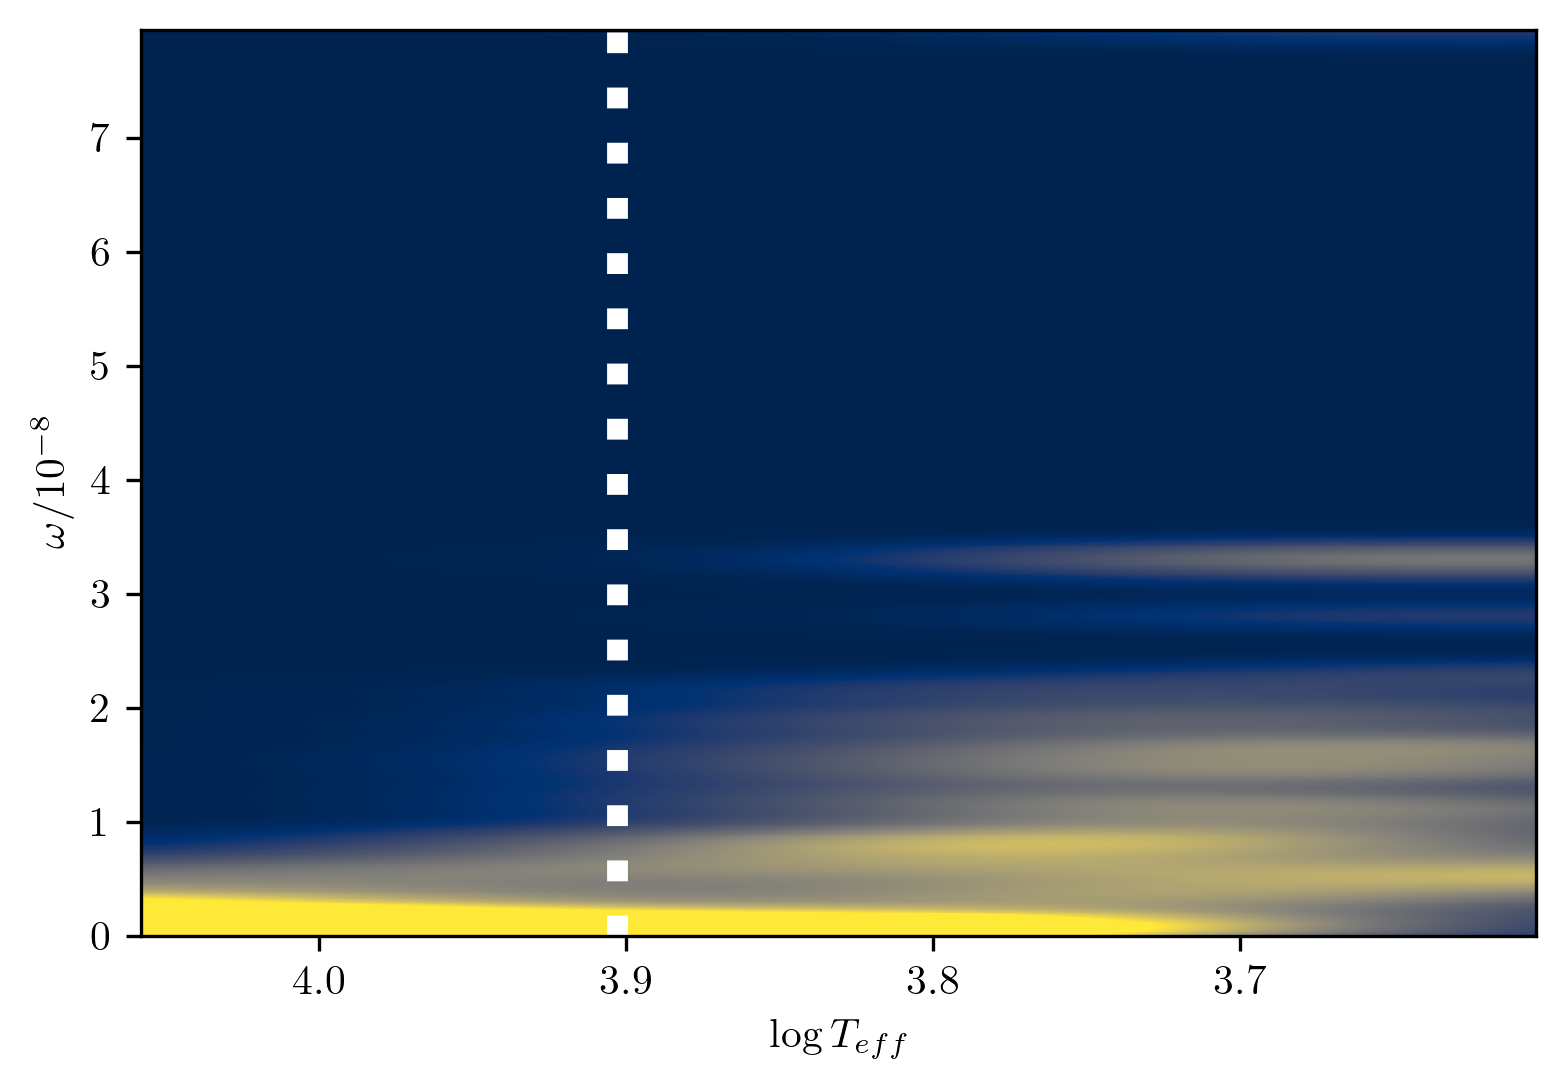

In [24]:
x_data = []
y_data = []
filter_high_frequencies = True
filter_many_frequencies = False
scale_tdyn = True
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn/1e-8
        y_data.append(y)
    
data = np.array([x_data,y_data]).T

params = {'bandwidth': np.arange(0.01,0.1,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data)

X, Y = np.meshgrid(np.linspace(np.min(data[:,0]),np.max(data[:,0]),1000), 
                   np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (1000,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

fig = plt.figure(dpi=300)
plt.pcolormesh(X, Y, Z_fteff_scale, shading='nearest', cmap='cividis', vmin=0, vmax=0.75)

ax = plt.gca()
ax.invert_xaxis()
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$\omega/10^{-8}$')

# aaaaand add in things with high frequencies...

0.09999999999999992


[Text(0.5, 0, '$\\log T_{eff}$'), Text(0, 0.5, '$\\omega/10^{-8}$')]

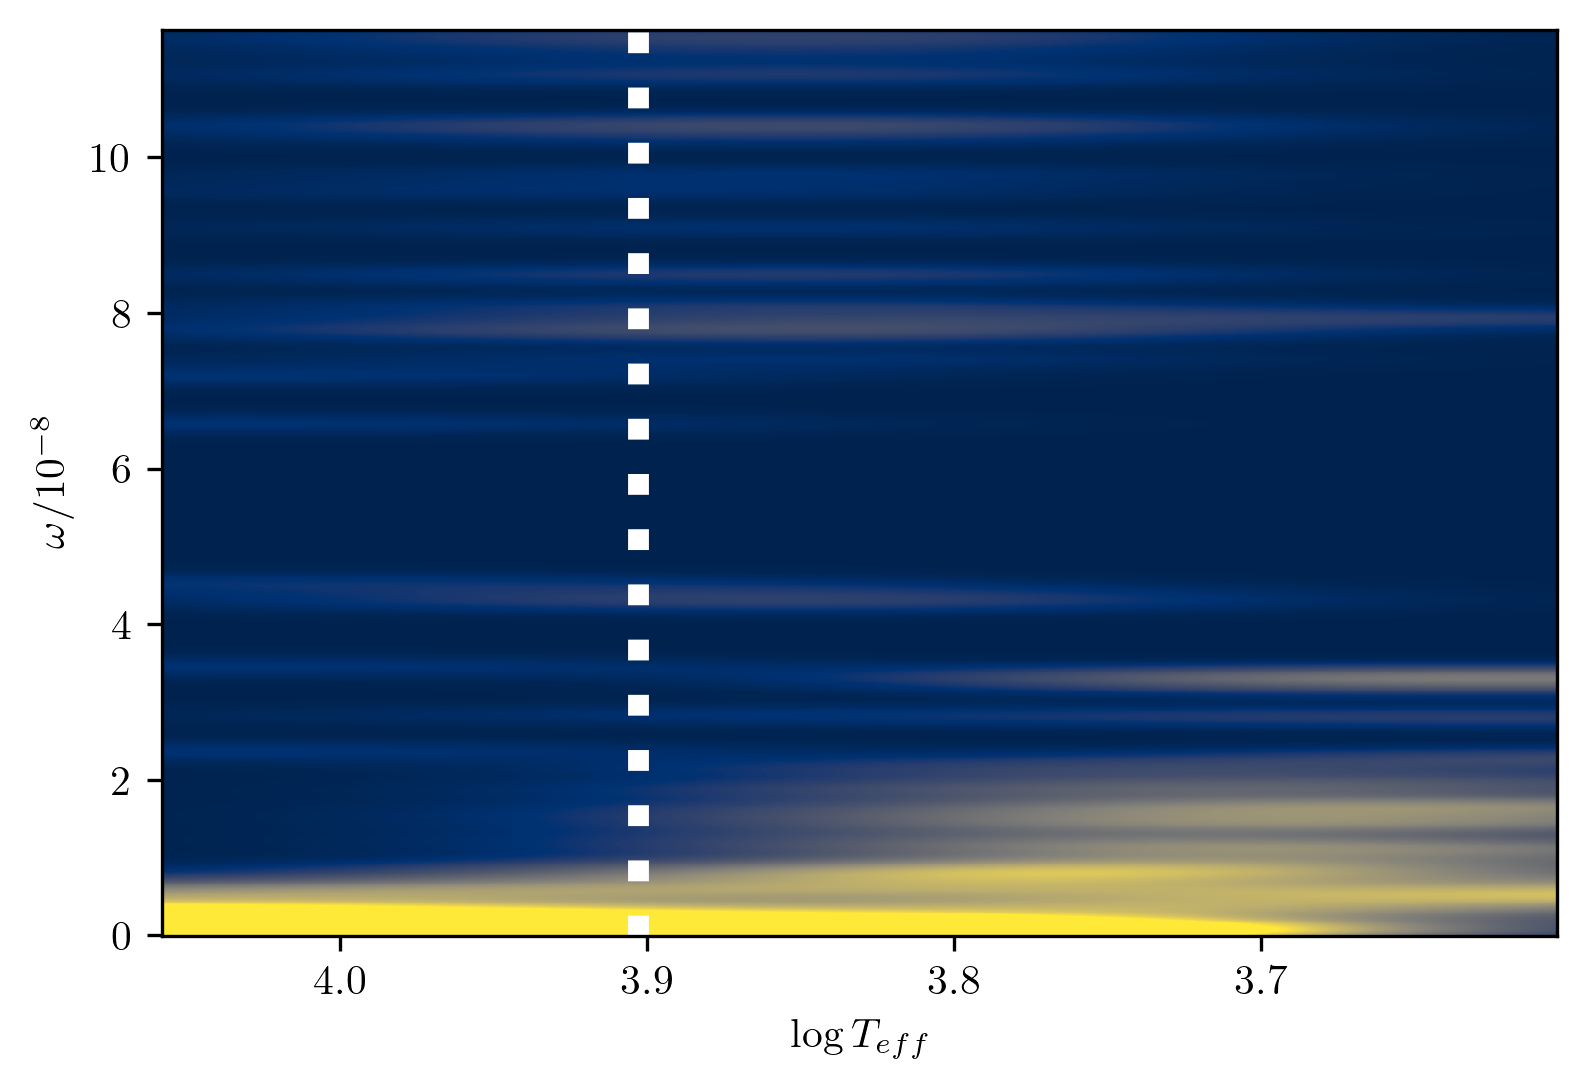

In [25]:
x_data = []
y_data = []
filter_high_frequencies = False
filter_many_frequencies = False
scale_tdyn = True
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn/1e-8
        y_data.append(y)
    
data = np.array([x_data,y_data]).T

params = {'bandwidth': np.arange(0.01,0.1,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data)

X, Y = np.meshgrid(np.linspace(np.min(data[:,0]),np.max(data[:,0]),1000), 
                   np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (1000,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

fig = plt.figure(dpi=300)
plt.pcolormesh(X, Y, Z_fteff_scale, shading='nearest', cmap='cividis', vmin=0, vmax=0.5)

ax = plt.gca()
ax.invert_xaxis()
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$\omega/10^{-8}$')

# Zooming in on the low frequency domain

0.09999999999999992


[Text(0.5, 0, '$\\log T_{eff}$'),
 Text(0, 0.5, '$\\omega/10^{-8}$'),
 (0.0, 2.0)]

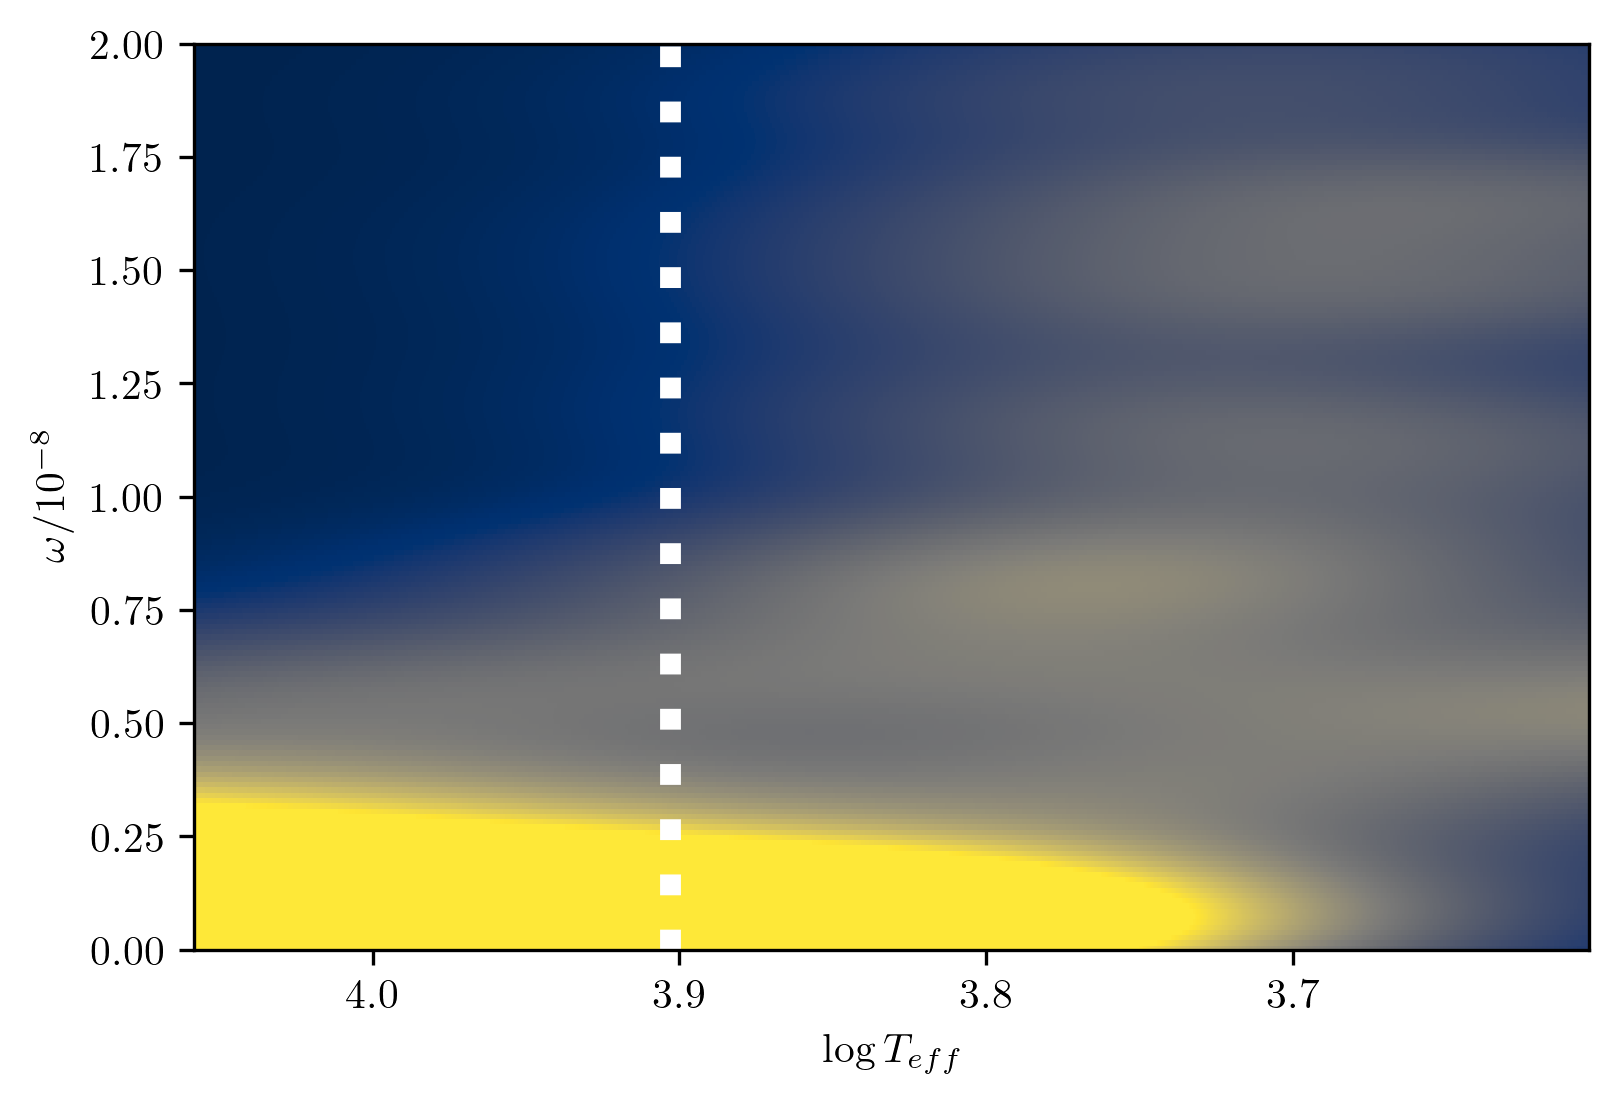

In [26]:
x_data = []
y_data = []
filter_high_frequencies = False
filter_many_frequencies = False
scale_tdyn = True
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn/1e-8
        y_data.append(y)
    
data = np.array([x_data,y_data]).T

params = {'bandwidth': np.arange(0.01,0.1,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data)

X, Y = np.meshgrid(np.linspace(np.min(data[:,0]),np.max(data[:,0]),1000), 
                   np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (1000,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

fig = plt.figure(dpi=300)
plt.pcolormesh(X, Y, Z_fteff_scale, shading='nearest', cmap='cividis', vmin=0, vmax=0.75)

ax = plt.gca()
ax.invert_xaxis()
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$\omega/10^{-8}$', ylim=(0,2))